In [2]:
#!pip install yfinance
!pip install py_vollib_vectorized

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 7.7 MB/s eta 0:00:00
  Created wheel for py-vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62832 sha256=08b9974908c484989ad733f76eb8445abb80d4180952823e82105018e3374804
  Stored in directory: /root/.cache/pip/wheels/c0/5c/8f/1ed590a10a2cca3cbfa7a7caa29fb5d729b3e1f819bfda4b5e
  Created wheel for py-lets-be-rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24450 sha256=a2f2b7388c64957534bd2a05c966b5fda8cd93a0cdba33dafc50b0d71a3b0288
  Stored in directory: /root/.cache/pip/wheels/d9/20/b1/018f644bacb669d5cd6af600fe09ee0729ae5d75875a9f3043
Successfully built py-vollib py-lets-be-rational


## Fixed Parameters:

Initializing simulation parameters...
Starting Heston model simulation...
Step 50/500: Mean asset price = 99.87140012094719, Mean variance = 0.05802339115323513
Step 100/500: Mean asset price = 99.90729812023896, Mean variance = 0.055326498896505816
Step 150/500: Mean asset price = 99.91115229192044, Mean variance = 0.050272181295742416
Step 200/500: Mean asset price = 100.38889055687929, Mean variance = 0.04678065653804763
Step 250/500: Mean asset price = 100.79858443746902, Mean variance = 0.0439128060530859
Step 300/500: Mean asset price = 101.18360239801407, Mean variance = 0.04163547451863454
Step 350/500: Mean asset price = 101.3021962718347, Mean variance = 0.04158138832878279
Step 400/500: Mean asset price = 101.35515925724575, Mean variance = 0.04324421533020094
Step 450/500: Mean asset price = 101.28239287621159, Mean variance = 0.04433424315816839
Step 500/500: Mean asset price = 101.17422919550394, Mean variance = 0.045233292941630865
Heston model simulation completed.
Simu

/usr/local/lib/python3.11/dist-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


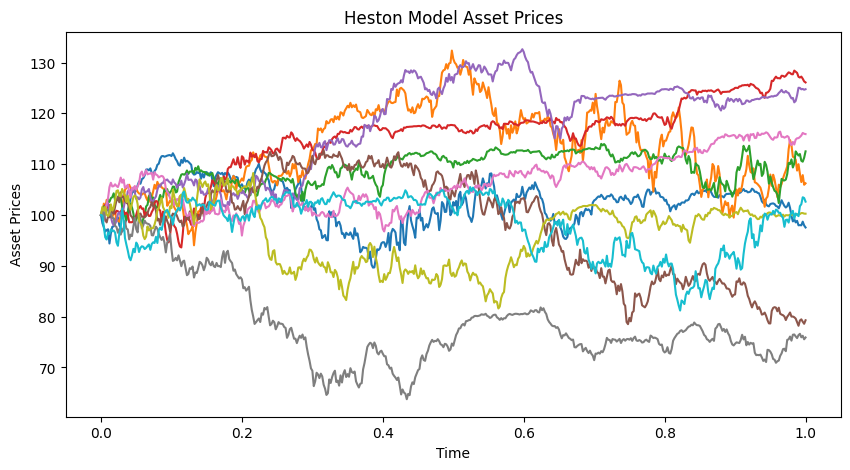

Generated Heston Model Asset Prices plot.


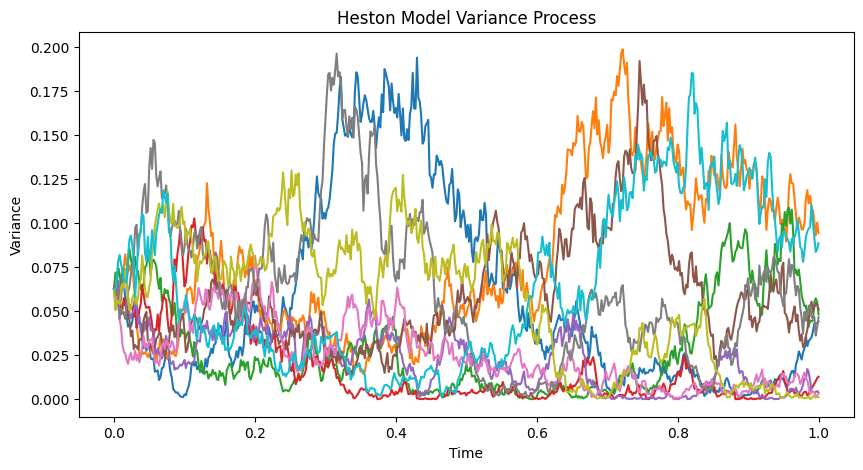

Generated Heston Model Variance Process plot.


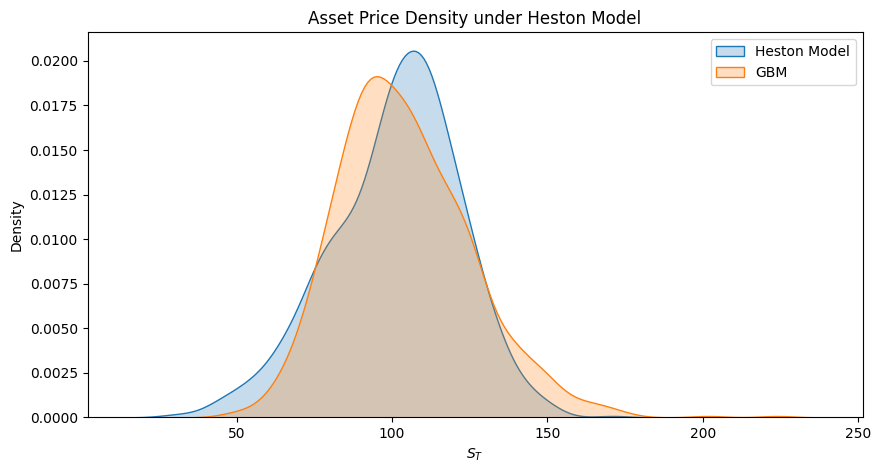

Generated Asset Price Density under Heston Model plot.


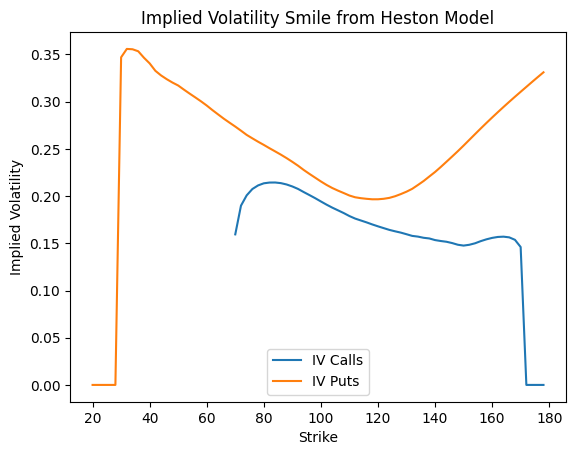

Plot generated successfully.


In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol


def heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M):
    print("Starting Heston model simulation...")
    dt = T / N
    mu = np.array([0, 0])
    cov = np.array([[1, rho], [rho, 1]])
    S = np.full((N + 1, M), S0)
    v = np.full((N + 1, M), v0)
    Z = np.random.multivariate_normal(mu, cov, (N, M))

    for i in range(1, N + 1):
        S[i] = S[i - 1] * np.exp((0.02 - 0.5 * v[i - 1]) * dt + np.sqrt(v[i - 1] * dt) * Z[i - 1, :, 0])
        v[i] = np.maximum(v[i - 1] + kappa * (theta - v[i - 1]) * dt + sigma * np.sqrt(v[i - 1] * dt) * Z[i - 1, :, 1], 0)
        if i % 50 == 0:
            print(f"Step {i}/{N}: Mean asset price = {np.mean(S[i])}, Mean variance = {np.mean(v[i])}")

    print("Heston model simulation completed.")
    return S, v

S0 = 100.0
T = 1.0
r = 0.02
N = 500
M = 1000
kappa = 3
theta = 0.20**2
v0 = 0.25**2
rho = -0.7
sigma = 0.6

print("Initializing simulation parameters...")
S, v = heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M)
print("Simulation completed. Computing implied volatilities...")
K = np.arange(20, 180, 2)
puts = np.array([np.exp(-r * T) * np.mean(np.maximum(k - S[-1], 0)) for k in K])
calls = np.array([np.exp(-r * T) * np.mean(np.maximum(S[-1] - k, 0)) for k in K])
print("Computed option prices.")
put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')
print("Computed implied volatilities.")

# Plot Heston Model Asset Prices
plt.figure(figsize=(10, 5))
time = np.linspace(0, T, N + 1)
plt.plot(time, S[:, :10])  # Plot 10 sample paths
plt.title('Heston Model Asset Prices')
plt.xlabel('Time')
plt.ylabel('Asset Prices')
plt.show()
print("Generated Heston Model Asset Prices plot.")

# Plot Heston Model Variance Process
plt.figure(figsize=(10, 5))
plt.plot(time, v[:, :10])  # Plot 10 sample paths
plt.title('Heston Model Variance Process')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.show()
print("Generated Heston Model Variance Process plot.")

# Plot Asset Price Density under Heston Model
plt.figure(figsize=(10, 5))
gbm = S0 * np.exp((r - theta ** 2 / 2) * T + np.sqrt(theta) * np.sqrt(T) * np.random.normal(0, 1, M))
sns.kdeplot(S[-1], label='Heston Model', fill=True)
sns.kdeplot(gbm, label='GBM', fill=True)
plt.title('Asset Price Density under Heston Model')
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()
print("Generated Asset Price Density under Heston Model plot.")

plt.plot(K, call_ivs, label='IV Calls')
plt.plot(K, put_ivs, label='IV Puts')
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.title('Implied Volatility Smile from Heston Model')
plt.legend()
plt.show()
print("Plot generated successfully.")


## Using real world data

Fetching options data for: AAPL
Available expiration dates: ('2025-03-07', '2025-03-14', '2025-03-21', '2025-03-28', '2025-04-04', '2025-04-17', '2025-05-16', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-10-17', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-06-17')
Selected expiration dates: ['2025-04-04', '2025-05-16', '2025-08-15', '2026-03-20']
Fetching option chain for expiration date: 2025-04-04
Fetching option chain for expiration date: 2025-05-16
Fetching option chain for expiration date: 2025-08-15
Fetching option chain for expiration date: 2026-03-20
Options data fetched successfully.
Initializing simulation parameters...
Starting Heston model simulation...
Step 50/252: Mean asset price = 147.3056954946049, Mean variance = 0.0519812352926446
Step 100/252: Mean asset price = 147.6085341047056, Mean variance = 0.046716295139227586
Step 150/252: Mean asset price = 148.6434625524435, Mean variance = 0.04280165190592063
S

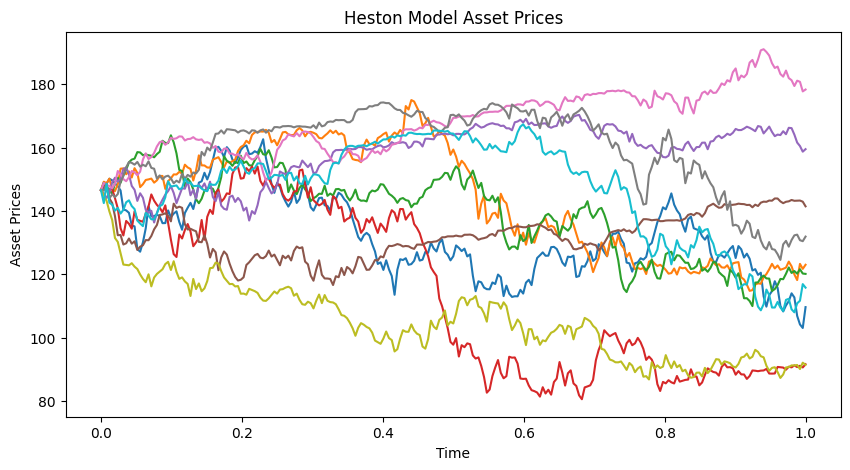

Generated Heston Model Asset Prices plot.


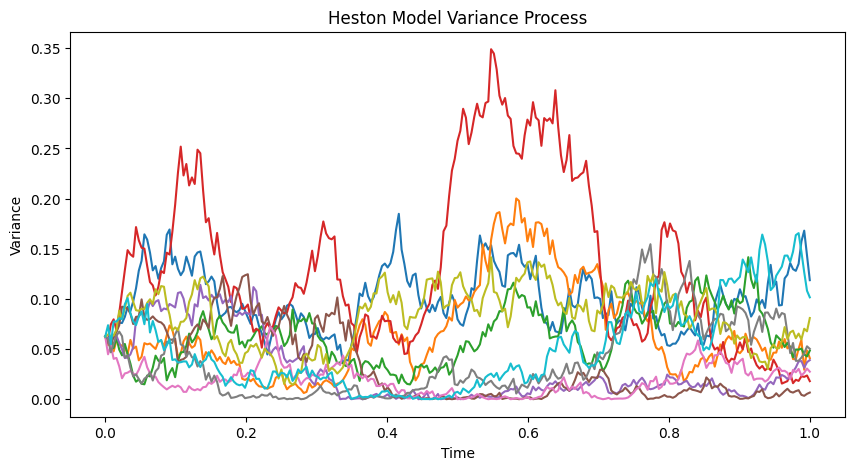

Generated Heston Model Variance Process plot.


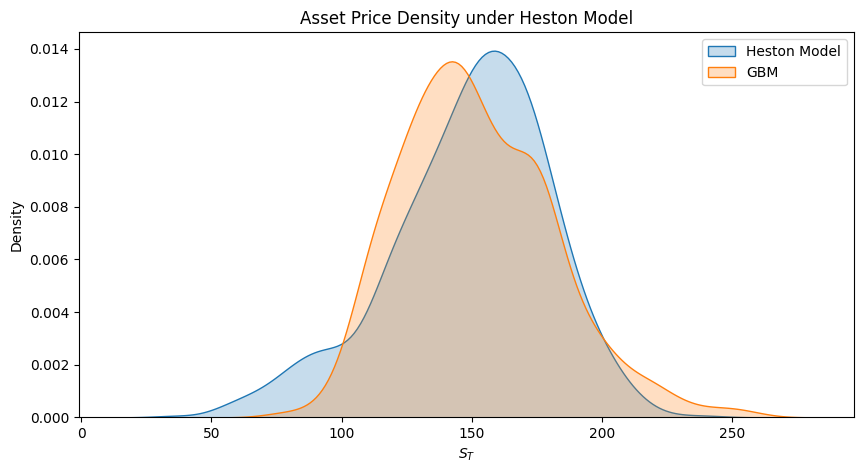

Generated Asset Price Density under Heston Model plot.


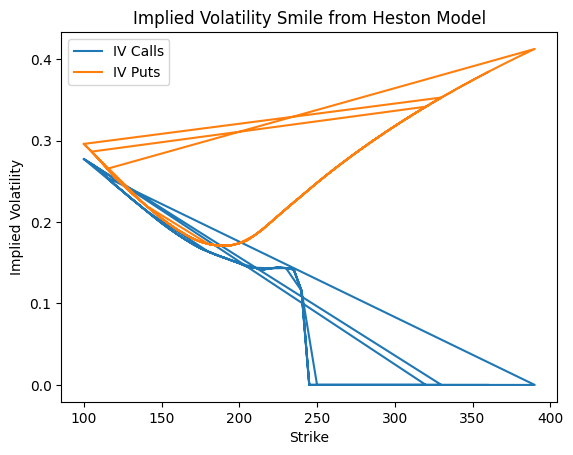

Plot generated successfully.


In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

def fetch_options_data(ticker_symbol):
    print(f"Fetching options data for: {ticker_symbol}")
    ticker = yf.Ticker(ticker_symbol)
    expiration_dates = ticker.options
    print(f"Available expiration dates: {expiration_dates}")
    exp_dates_dt = [dt.strptime(date, "%Y-%m-%d") for date in expiration_dates]
    today = dt.today()
    target_maturities = [30, 90, 180, 365]
    selected_exp_dates = []

    for target in target_maturities:
        closest_date = min(exp_dates_dt, key=lambda x: abs((x - today).days - target))
        if closest_date not in selected_exp_dates:
            selected_exp_dates.append(closest_date)

    selected_exp_dates = [date.strftime("%Y-%m-%d") for date in selected_exp_dates]
    print(f"Selected expiration dates: {selected_exp_dates}")

    all_calls_data = []
    for exp_date in selected_exp_dates:
        print(f"Fetching option chain for expiration date: {exp_date}")
        option_chain = ticker.option_chain(exp_date)
        calls_df = option_chain.calls.copy()
        calls_df["expiration_date"] = exp_date
        all_calls_data.append(calls_df)

    options_data = pd.concat(all_calls_data, ignore_index=True)
    print("Options data fetched successfully.")
    return options_data, selected_exp_dates[0]

# Fetch real-world data
options_data, selected_exp_dates = fetch_options_data("AAPL")
S0 = options_data['lastPrice'].iloc[0]  # Use latest AAPL stock price
K = options_data['strike'].values  # Use real strike prices

def heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M):
    print("Starting Heston model simulation...")
    dt = T / N
    mu = np.array([0, 0])
    cov = np.array([[1, rho], [rho, 1]])
    S = np.full((N + 1, M), S0)
    v = np.full((N + 1, M), v0)
    Z = np.random.multivariate_normal(mu, cov, (N, M))

    for i in range(1, N + 1):
        S[i] = S[i - 1] * np.exp((0.02 - 0.5 * v[i - 1]) * dt + np.sqrt(v[i - 1] * dt) * Z[i - 1, :, 0])
        v[i] = np.maximum(v[i - 1] + kappa * (theta - v[i - 1]) * dt + sigma * np.sqrt(v[i - 1] * dt) * Z[i - 1, :, 1], 0)
        if i % 50 == 0:
            print(f"Step {i}/{N}: Mean asset price = {np.mean(S[i])}, Mean variance = {np.mean(v[i])}")

    print("Heston model simulation completed.")
    return S, v

T = 1.0
r = 0.02
N = 252
M = 1000
kappa = 3
theta = 0.20**2
v0 = 0.25**2
rho = -0.7
sigma = 0.6

print("Initializing simulation parameters...")
S, v = heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M)
print("Simulation completed. Computing implied volatilities...")
puts = np.array([np.exp(-r * T) * np.mean(np.maximum(k - S[-1], 0)) for k in K])
calls = np.array([np.exp(-r * T) * np.mean(np.maximum(S[-1] - k, 0)) for k in K])
print("Computed option prices.")
put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')
print("Computed implied volatilities.")

# Plot Heston Model Asset Prices
plt.figure(figsize=(10, 5))
time = np.linspace(0, T, N + 1)
plt.plot(time, S[:, :10])  # Plot 10 sample paths
plt.title('Heston Model Asset Prices')
plt.xlabel('Time')
plt.ylabel('Asset Prices')
plt.show()
print("Generated Heston Model Asset Prices plot.")

# Plot Heston Model Variance Process
plt.figure(figsize=(10, 5))
plt.plot(time, v[:, :10])  # Plot 10 sample paths
plt.title('Heston Model Variance Process')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.show()
print("Generated Heston Model Variance Process plot.")

# Plot Asset Price Density under Heston Model
plt.figure(figsize=(10, 5))
gbm = S0 * np.exp((r - theta ** 2 / 2) * T + np.sqrt(theta) * np.sqrt(T) * np.random.normal(0, 1, M))
sns.kdeplot(S[-1], label='Heston Model', fill=True)
sns.kdeplot(gbm, label='GBM', fill=True)
plt.title('Asset Price Density under Heston Model')
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()
print("Generated Asset Price Density under Heston Model plot.")

plt.plot(K, call_ivs, label='IV Calls')
plt.plot(K, put_ivs, label='IV Puts')
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.title('Implied Volatility Smile from Heston Model')
plt.legend()
plt.show()
print("Plot generated successfully.")
